# Using LLMs as High-Level Planners for Multi-Agent Coordination

This notebook provides a step-by-step guide to customizing and interacting with the RL environment.

## For Submission
1. Fill in your code in `submit.py`. 
   - Add your code *only* in the TODO sections marked by the '#' delimiter lines. Do not modify any other parts of the script.
   - You should implement any helper functions/classes in a separate `helper.py` file and import them in `submit.py`.
1. Submit `out.log` and `results.csv` generated by the `submit.py` script.


In [8]:
# Import necessary libraries and modules
import gymnasium as gym
import multigrid.envs
import matplotlib.pyplot as plt
from agents import AgentCollection
from IPython.display import clear_output

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
## Initial Plan Generation

An intial plan can be generated by the `initial_planner` by invoking it with the grid size and number of agents available.

In [18]:
import configparser

config = configparser.ConfigParser()
config.read("env_config_test.ini")

environments = {}
for section in config.sections():
    M = config.getint(section, "number_of_agents")
    N = config.getint(section, "grid_size")
    goals = eval(config.get(section, "goals"))
    mission_statement = eval(config.get(section, "mission_statement"))
    # num_trials = config.getint(section, "number_of_trials")
    environments[section] = {
        "N": N,
        "M": M,
        "goals": goals,
        "mission_statement": mission_statement,
    }

In [19]:
from models import local_llm as llm
from planner import SuperPlanner as Planner

In [15]:
plans = []
selected_env = environments["env.0"]
env = multigrid.envs.EmptyEnvV2(
    size=selected_env["N"],  # Specify the size of the grid, N
    agents=selected_env["M"],  # Specify number of agents, M
    goals=selected_env["goals"],  # Specify target positions for agents
    mission_space=selected_env["mission_statement"],
    render_mode="rgb_array",
    hidden_goals=True,
    # max_steps=50, # For debugging, you can set a maximum number of steps
)

# Always reset the environment before starting
observations, infos = env.reset()

agents = AgentCollection(num=selected_env["M"])

planner = Planner(
    llm=llm, grid_size=selected_env["N"], observations=observations, infos=infos
)

# Providing the agents with high-level instructions
mission = observations[0]["mission"]
text_plan, plan = planner.initial_plan()
for agent, actions in plan.items():
    for action in actions:
        agents.tell({agent: action.serialize()})
plans.append((text_plan, plan))

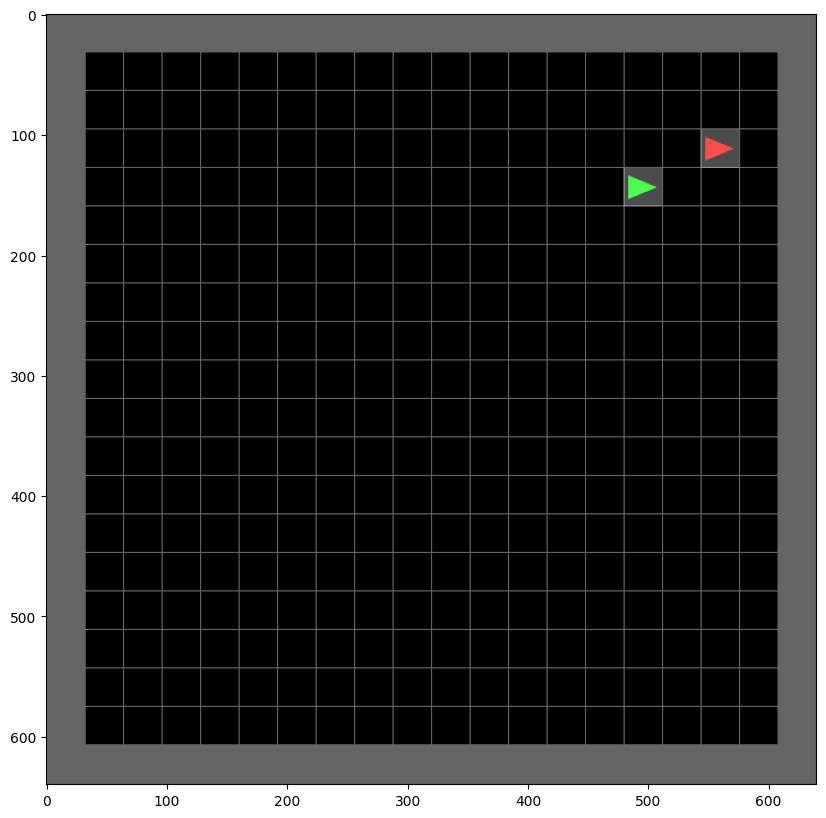

75.06181349533605


In [16]:
steps = 0
while not env.unwrapped.is_done():
    steps += 1
    # Obtain the low-level action for current time step for all agents
    a = agents.act()

    # Step the environment with the actions
    observations, rewards, terminations, truncations, infos = env.step(a)

    if steps % 1 == 0:
        # Render the environment
        clear_output(wait=True)
        img = env.render()
        plt.figure(figsize=(10, 10))
        plt.imshow(img[::-1, :])
        plt.show()

    if env.unwrapped.is_done():
        break

    text_plan, plan = planner.replan(
        agents, observations, rewards, terminations, truncations, infos
    )
    plans.append((text_plan, plan))
    for agent, actions in plan.items():
        agents.tell({agent: "stop()"})
        for action in actions:
            agents.tell({agent: action.serialize()})


print(infos["total_reward"])
env.close()

In [111]:
plans

[('We are on a 20×20 grid with 2 agents starting at (1,1). Walls exist at row 0, row 19, column 0, and column 19. The interior searchable area is rows 1–18 and columns 1–18. The coordinate system has (0,0) as the South-West (bottom-left) corner and (19,19) as the North-East (top-right) corner.\n\nThe mission indicates two target-rich regions:\n- Region A: (1,1) to (5,5), containing 1 target (this spans 5×5 = 25 cells).\n- Region B: (10,10) to (16,16), containing 1 target (this spans 7×7 = 49 cells).\n\nTotal cells in mission-specified regions: 25 + 49 = 74 cells.\nTotal interior cells: 18×18 = 324 cells.\nUnmentioned interior area: 324 - 74 = 250 cells — this includes large unsearched zones such as the bottom-left periphery (e.g., (1,6) to (9,9)), top-right periphery (e.g., (17,17) to (18,18)), and the central corridor between the two regions.\n\nPartitioning Strategy:\n- Region A (1,1)-(5,5): small (25 cells), easily searched by one agent. Assign to Agent 0.\n- Region B (10,10)-(16,16